# Reuters Clustering Example

## Load data

In [1]:
# Install transformers
!pip install transformers

     |████████████████████████████████| 2.3MB 5.4MB/s 
     |████████████████████████████████| 901kB 26.7MB/s 
     |████████████████████████████████| 3.3MB 40.0MB/s 


In [2]:
# Import libraries

# Main
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# NLP
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Transformers
from transformers import AutoTokenizer, TFAutoModel

# Sklearn
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from IPython.display import clear_output

In [3]:
# Download data set
nltk.download('wordnet')
nltk.download('reuters')
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_d

In [4]:
from nltk.corpus import reuters

In [5]:
# Extract dataset
raw_data = []
raw_labels = []
for file in reuters.fileids():
  raw_data.append(reuters.raw(file))
  raw_labels.append(reuters.categories(file))

In [6]:
# let's consider only 5 categories
our_labels = ['crude', 'jobs', 'grain', 'gold', 'coffee']

# def arrays
data = []
labels = []

# Extract only 5 categories
for i in range(len(raw_labels)):
    if any(item in raw_labels[i] for item in our_labels) and len(raw_data[i].split())<300:
        data.append(raw_data[i])
        labels.append(raw_labels[i])

In [7]:
# Code labels to just one number
new_labels = []
for label in labels:
    for i, our_lb in enumerate(our_labels):
      if our_lb in label :
        new_labels.append(i)
        break

## Preprocessing

In [8]:
# Colloquial dict contractions
contraction_colloq_dict = {"btw": "by the way", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "where's":"where is"}

# Process text
def process_text(text, tokenizer, lemmatizer):
    """ Applies standard pre-processing to given text.
    
    Args:
        p (gensim.parsing.porter.PorterStemmer): stemmer object.
        tokenizer (nltk.tokenize.regexp.RegexpTokenizer): tokenizr object.
        text (str): text to preprocess.
    
    Returns:
        list: preprocessed text.
    
    """
    # Converts to lowercase
    text_lc = text.lower()
    
    # Replace colloquial terms
    for word in text_lc.split():
        if word in list(contraction_colloq_dict.keys()):
            text_lc = text_lc.replace(word, contraction_colloq_dict[word])
    
    # Removes stopwords
    text_sw = remove_stopwords(text_lc)
    
    # Stems text
    #text_stem = p.stem_sentence(text_sw)
    
    # Tokenizes text and removes punctuation
    #text_tk = tokenizer.tokenize(text_lc)
    
    # Lemmatizes text
    #text_lm = []
    #for word in text_tk:
    #    text_lm.append(lemmatizer.lemmatize(word))
         
    # Returns preprocessed text
    return text_sw

In [9]:
# Creates lemmatizer instance
lemmatizer = nltk.stem.WordNetLemmatizer()
# Creates RegexpTokenizer (removes punctuation signs)
tk = nltk.RegexpTokenizer(r'\w+')

corpus = []
for d in data:
  corpus.append(process_text(d, tk, lemmatizer))

## BERT Embedding

In [10]:
# Bert instance
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model = TFAutoModel.from_pretrained("distilbert-base-uncased", output_hidden_states=True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
# Test Model for first sentence
inputs = tokenizer(corpus[0], padding='max_length', return_tensors="tf")
outputs = model(**inputs)

# Just pooler output as embeddings
embedding = outputs['pooler_output'][0].numpy()

In [15]:
# Array to save embeddings
bert_embeddings = []

for i, doc in enumerate(corpus):
  # Run Bert for each document
  inputs = tokenizer(doc, return_tensors="tf")
  outputs = model(**inputs)

  # CLS Token
  embedding = outputs['pooler_output'][0].numpy()

  # Sum of all layers
#  embedding = tf.reshape(outputs['hidden_states'][-1], 512*768).numpy()
#  for hs in range(2,8):
#    embedding += tf.reshape(outputs['hidden_states'][-hs], 512*768).numpy()

  bert_embeddings.append(embedding)
  print(f'Tokenizing Doc {i}')
  clear_output(wait=True)

Tokenizing Doc 1217


## Clustering

In [104]:
# Principal component analysis for dim reduction (optional)
pca = PCA(n_components=2)
X = pca.fit_transform(bert_embeddings)

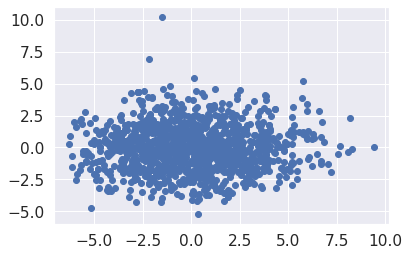

In [113]:
plt.scatter(X[:,0],X[:,1])

In [116]:
k_means = KMeans(5, max_iter = 300)
clusters_kmeans = k_means.fit_predict(bert_embeddings)

In [120]:
agg_clustering = AgglomerativeClustering(n_clusters=5)#, linkage='average', affinity='cosine')
clusters_agg = agg_clustering.fit_predict(bert_embeddings)

In [114]:
spectral_clustering = SpectralClustering(n_clusters=5, assign_labels='discretize')
clusters_spec = spectral_clustering.fit_predict(bert_embeddings)

## Results

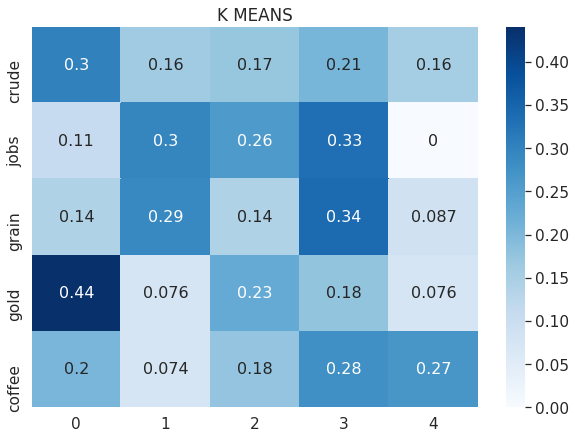

In [123]:
import seaborn as sn

# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_kmeans, normalize='true')

# Plot
df_cm = pd.DataFrame(matrix, ['crude', 'jobs','grain', 'gold', 'coffee'], range(5))
plt.figure(figsize=(10,7))
plt.title('K MEANS')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

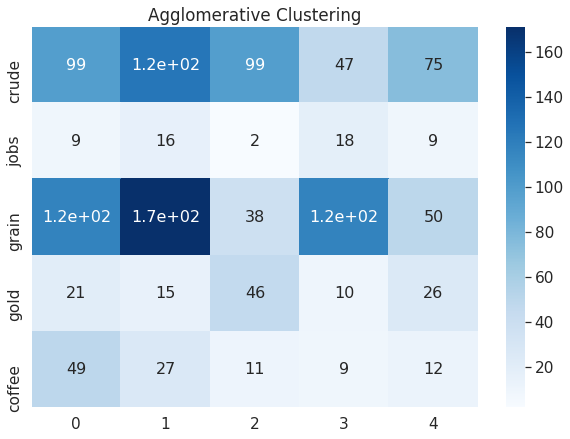

In [135]:
# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_agg)

# Plot
df_cm = pd.DataFrame(matrix, ['crude', 'jobs','grain', 'gold', 'coffee'], range(5))
plt.figure(figsize=(10,7))
plt.title('Agglomerative Clustering')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

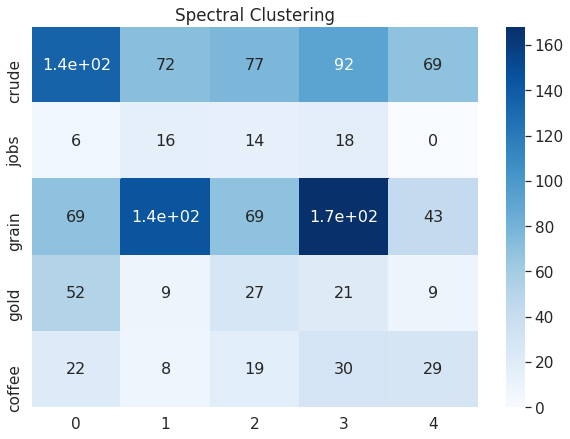

In [134]:
# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_kmeans)

# Plot
df_cm = pd.DataFrame(matrix, ['crude', 'jobs','grain', 'gold', 'coffee'], range(5))
plt.figure(figsize=(10,7))
plt.title('Spectral Clustering')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()